# Convective fit all
averaged over the last portion of the simulation



In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
from pylab import *
import scipy.integrate as integrate
#from cmocean import cm as cmo
import matplotlib.gridspec as gridspec
import matplotlib.ticker 
import scipy.stats as stats
import scipy.optimize as optimize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import savgol_filter
from scipy.ndimage import uniform_filter
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## This function loads all runs and calculates quantities necessary for comparing the scaling analysis.

In [81]:
#%% Pick the filename and path
files = [
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_MS.h5',
             '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2_MS.h5',
       '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p06/snapshots/snapshots_1e-6_0p06_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-6_0p02/snapshots/snapshots_5e-6_0p02.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p02/snapshots/snapshots_1e-7_0p02_MS.h5',
         '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005_MS.h5',
        ]




molec = 0 # Flag (0,1) for including subgrid terms in finding zeros of vertical buoyancy flux
molec2= 0
wbmax = []
wbmin = []
factor = []
ydata = []
hntotal = []
Htotal = []
vbf = []
vpwp = []
vpwpscale = []
enttotal = []
moment = []
betatotal = []
vpwpa = []
vbfa = []
test = []
MOdepth =[]
Ball =[]
ustartotal = []
S2a=[]
EBFa=[]
bfh=[]
bfb=[]
vpwpi = []
vbfi = []
zall = []
ydatah=[]
wpbpi = []
vpwph = []
vzh = []
flagfirst = True
for filename in files:
    print(filename)
    f = h5py.File(filename, 'r')
    print('Loaded')
    # Get the data
    data = list(f['tasks'])

    # Basic parameters
    N = f['tasks']['N'][0,0,0] #Interior stratification (background)
    tht = f['tasks']['tht'][0,0,0] # Slope angle
    print(f'Processing N = {N}, theta = {tht}')

    # Load variables in physical space
    b = f['tasks']['b'] # Perturbation buoyancy
    v = f['tasks']['v'] # Along-slope direction
    u = f['tasks']['u'] # Along-slope direction

    vbfr = f['tasks']['VBFrotated']
    VPWP = f['tasks']['GSProtated'][:,:,:]*1e-4/(N**2*np.sin(tht))
    #vbfrot = f['tasks']['VBFrotated']
    z = v.dims[2][0][:]
    time = v.dims[0][0][:]
    q = f['tasks']['PV']
    wq = f['tasks']['wq']
    print('Begin calcs')
    qm = np.mean(q, axis=1)
    Qo = 1e-4*N**2
    vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
    uz = np.gradient(np.mean(u, axis=1), axis=-1)/np.gradient(z)
    bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
    # Calculate BEk
    tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
    taux = -1035*1e-4*uz[:,0]
    
    S2 = N**2*tht**2/1e-8
    Bek = -(tauy/(1030*1e-4)*N**2*np.sin(tht))/(1+S2)

    ws = f['tasks']['ws']
    bs = f['tasks']['bs']
    kx = f['scales/kx'][:]/(2*np.pi) # Inverse wavelengths in cross-front direction
    kcut = np.where(kx<(1/100))[0]
    kcut = kcut[-1]
    vbfs = 2*np.real(np.conj(ws)*bs)
    vbfh = np.sum(vbfs[:,kcut:,:], axis=1)
    
    # Calculate h
    print('Calculations Complete')
    
    nt = time.size
    avgt = 18*2*1
    #avgt = 18*4
    for i in range(1, nt-avgt+1, avgt):
        ti = range(i, i+avgt)
        qmean = np.mean(qm[ti,:], axis=0) #direct calculation of Q
        
        # Try a direct calculation of H and entrainment
        # Options are to define relative to Qo or as the place the PV flux is 0 (noisy?)
        indq = np.where(qmean>0.75*Qo)[0][0]    
        H = z[indq] # pick out H
        
        
        ent = np.mean(vbfr[ti,0,indq] - molec*1e-4*(bz[ti,indq])) #these are the buoyancy entrainment fluxes at this depth

        # Find where h is (where vert. buoyancy flux is 0)
        #Average the vert buoyancy flux (molec turns on subgrid terms)
        vsmooth = np.mean(vbfr[ti,0,:]- molec*1e-4*(bz[ti,:]), axis=0)
        inds = np.where(np.logical_and(vsmooth<0, z<=H))[0]
        #inds = np.where(np.logical_and(vsmooth<0, np.logical_and(z<=H, z>10)))[0] # Note ad hoc use of z>10...
        if inds.size == 0:
            print('No Ind: ' + filename)
            hn = H
        else:
            inds = [inds[0]]
            hn = z[inds[0]]

            Beka = np.mean(Bek[ti])
            Ha = H
            ha = hn

            ustar = np.sqrt(np.abs(np.mean((0*taux + 1j*tauy)[ti], axis=0)/1035))
            ustartotal.append(ustar)
            
            ydataPartial = ha/Ha     #y is the ratio of h/H
            entPartial = 1 - ent/(Beka + 0e-4*N**2*(1-S2/(1+S2))) # Define the entrainment factor 

            # Some options for defining the velocity scale 
            # include interior velocity, friction velocity, or interior velocity normalized by h/H
#             valt = hn*(1e-4*S2/np.tan(tht[0,0,0])/(1+S2))
            valt = 0.1
#             valt = np.mean(np.sqrt(np.abs(tauy[ti])/1030))
            
            vpwpscale.append((Beka*(ha))**(1/3)*(ha)*N**2*tht/((1+S2)*1e-4)) # Save a scaling estimate
            #vpwpscale.append((Beka*ha)**(1/3)*ustar)
            #vpwpscale.append(ustar**2)
            #vpwpscale.append(0.4*(0*1.26*ustar**3 + 8.38*0.4*0.1*Beka*ha)**(1/3)*ustar) #KPP scaling from Large et al. 1994
            #vpwpscale.append(0.4*(0*1.26*ustar**3 + 8.38*0.4*0.1*Beka*ha)**(1/3)*0.1) #KPP scaling from Large et al. 1994
            
            #vpwpscale.append((-Beka*ha)**(1/3)*ha*N**2*tht/1e-4) # Save a scaling estimate
            
            #vpwpscale.append((-Beka*Ha)**(1/3)*ustar)
            #vpwpscale.append((-Beka*Ha)**(1/3)*Ha*N**2*tht/1e-4)
            #vpwpscale.append(ustar*ha/((1+S2)*ustar*1e-4/(0.4*tht*N**2))*0.1*0.4)
            #vpwpscale.append((Beka*(1+S2)*(1-ydataPartial))*1e-4/(N**2*tht))# Assuming N^2*tht/f*<v'w'> ~ Bek*(z+H)/H
            #vpwpscale.append(np.mean(tauy[ti]/1030)*(1-ydataPartial))
            #vpwpscale.append((-Beka*ha)**(1/3)*0.1*(1-ydataPartial))
            vpwp.append(np.mean(VPWP[ti,0,inds[0]]-molec*1e-4*vz[ti,inds[0]], axis=0))

            enttotal.append(entPartial)
            #factor.append( factorPartial)
            ydata.append(ydataPartial)
            hntotal.append(ha)
            Htotal.append(Ha)
            S2a.append(S2)
            
            vbfa.append(np.mean(vbfr[ti,0,:], axis=0)) #slope normal buoyancy flux
            vpwpa.append(np.mean(VPWP[ti,0,:],axis=0))
            zall.append(z)
            MOdepth.append((1+S2)*ustar*1e-4/(0.4*tht*N**2))
            #test.append(np.sqrt(np.abs(np.mean(tauy[ti]))/1030))
            #test.append((np.mean(np.abs(tauy[ti]))/(1030*(1+S2)))**2*1e-4/(N**2*tht*0.1**3))
            #test.append(N**2*tht*valt*(-Beka*Ha)**(1/3)/1e-4)
            test.append(N**2*tht/(1e-4)/(1+S2))
            Ball.append(Beka)
            bfb.append(1e-4*N**2)
            wbmax.append(np.max(np.mean(vbfr[ti,0,:], axis=0)))
            wbmin.append(np.min(np.mean(vbfr[ti,0,:], axis=0)))
            vbfi.append(integrate.trapz(np.mean(vbfr[ti,0,0:], axis=0), x=z[0:]))
            vpwpi.append(integrate.trapz(np.mean(VPWP[ti,0,0:], axis=0), x=z[0:]))
            
            # Do high wavenumber version
            vsmooth = np.mean(vbfh[ti,:]- molec*1e-4*(bz[ti,:]), axis=0)
            #inds = np.where(np.logical_and(vsmooth>0, z<=H*0.5))[0]
            #if inds.size == 0:
            #    inds = np.where(np.logical_and(vsmooth>0, z<=H))[0]
            zm = 0.5*(z[1:]+z[0:-1])
            inds = np.where(np.logical_and(np.diff(np.signbit(vsmooth)), np.logical_and(zm>0.5, zm<H*0.5)))[0]
            if inds.size == 0:
                inds = np.where(np.logical_and(np.diff(np.signbit(vsmooth)), np.logical_and(zm>1, zm<H)))[0]

            #indmax = np.argmax(vsmooth)
            #inds = np.where(np.logical_and(vsmooth<0.05*np.max(vsmooth), z>z[indmax]))[0] 
            #inds = np.where(np.logical_and(vsmooth<0, np.logical_and(z<=H, z>10)))[0] # Note ad hoc use of z>10...
            if inds.size == 0:
                print('No Spectral Ind: ' + filename)
                ydatah.append(1)
                wpbpi.append(0)
                vpwph.append(0)
                bfh.append(0)
                vzh.append(0)
            else:
                inds = [inds[0]]
                ydatah.append(z[inds[0]]/Ha)
                wpbpi.append(np.mean(vbfr[ti,0,inds[0]]))
                vpwph.append(np.mean(VPWP[ti,0,inds[0]]))
                bfh.append(1e-4*np.mean(bz[ti,inds[0]]))
                vzh.append(np.mean(1e-4*vz[ti,inds[0]], axis=0))

            #if flagfirst:
            #    vbf = np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]), axis=0)[:,np.newaxis]
            #    flagfirst = False
            #else:
            #    vbf = np.concatenate((vbf,np.mean(vbfr[ti,0,:]-molec*1e-4*(bz[ti,:]), axis=0)[:,np.newaxis]), axis=-1)
    f.close()

factor = np.array(factor)
ydata = np.array(ydata)
ydatah = np.array(ydatah)
hntotal = np.array(hntotal)
Htotal = np.array(Htotal)
test = np.array(test)
Ball = np.array(Ball)
vpwp = np.array(vpwp)
enttotal = np.array(enttotal)
ustartotal = np.array(ustartotal)
S2a  = np.array(S2a)
betatotal = np.array(betatotal)
moment = np.array(moment)
bfh = np.array(bfh)
bfb = np.array(bfb)
wbmax = np.array(wbmax)
wbmin = np.array(wbmin)
vbfi = np.array(vbfi)
vpwpi = np.array(vpwpi)
wpbpi = np.array(wpbpi)
vpwph = np.array(vpwph)
vzh = np.array(vzh)

/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.1
Begin calcs
Calculations Complete
No Spectral Ind: /data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p1/snapshots/snapshots_1e-5_0p1_MS.h5
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05_LONG.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.05
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p1/snapshots/snapshots_1e-6_0p1_MS.h5
Loaded
Processing N = 0.001, theta = 0.1
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02_LNG.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.019999999999999997
Begin calcs
Calculations Complete
/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02_V2/snapshots/snapshots_1e-5_0p02_V2_MS.h5
Loaded
Processing N = 0.0031622776601683785, theta = 0.0199999999999

In [ ]:
plt.plot(Ball/bfb)
plt.plot(Ball/bfh)

In [ ]:
inds = np.where(np.logical_and(np.diff(np.signbit(vsmooth)), 0.5*(z[1:]+z[0:-1])<Ha*0.5))[0]
#(z<Ha*0.5).shape
print(inds)
plt.plot(vsmooth, z)
plt.plot(0*inds, z[inds], marker='x')

In [ ]:
plt.plot(ydatah*Htotal)
plt.plot(Htotal)

In [ ]:
plt.plot(vpwp)
plt.plot(-1e-2*(-Htotal*(1-ydata)*test + 0.1)*ustartotal)
plt.plot(-2e-4*(-Htotal*(1-ydata)*test + 0.1)**2)
plt.plot(-5e-3*(-Htotal*(1-ydata)*test + 0.1)*(Ball*Htotal)**(1/3))


In [ ]:
moment = np.array(moment)
plt.plot(vpwp)
plt.plot(ustartotal**2/(1-ydata*Htotal/MOdepth))
plt.ylim(-2e-5, 0)

In [ ]:
plt.plot(ydata)
plt.plot(ydatah)

In [ ]:
factor = np.array(factor)
ydata = np.array(ydata)
hntotal = np.array(hntotal)
Htotal = np.array(Htotal)
test = np.array(test)
Ball = np.array(Ball)
vpwp = np.array(vpwp)
enttotal = np.array(enttotal)
ustartotal = np.array(ustartotal)
S2a  = np.array(S2a)
betatotal = np.array(betatotal)

In [ ]:
plt.plot(ydata)
plt.plot(S2a)
plt.ylim(0,1)

In [ ]:
plt.plot(ustartotal)
plt.plot(np.sqrt(2e-3)*(0.1 - test*Htotal)*np.sqrt(ydata))

## Check $\langle v'w' \rangle$ scaling

In [ ]:
plt.figure()
#num = np.mean(np.array(vpwpa)**(1), axis=1)
num = vpwp
#scale = -(np.array(vpwpscale)*(1-ydata*0.4*ustartotal/1e-4/Htotal))
scale =   (np.array(vpwpscale))
wstar = np.array(vpwpscale/test)
scale = np.array(vpwpscale)
scale = Ball*(1-0.4*ydata-1.2*ydata**2)/test - 0*ustartotal**3/(0.4*ydata*Htotal)*(1-ydata-ydata**2)/test
scale = (Htotal*ydata)**2*(0.3-ydata)**2*test**2
#scale = (0.1 - test*Htotal)**2
#scale = np.array(vpwpscale)
#scale = (ustartotal**6 + np.array(vpwpscale)**3)**(1/3)
#scale = -ustartotal**2*(1-ydata)
plt.scatter(num, scale, c=np.log10(MOdepth/(Htotal)))
plt.colorbar()
mask = np.logical_and(MOdepth/(Htotal)<1, ydata>5e-3)
plt.scatter(np.array(num)[mask], np.array(scale)[mask], marker='x')

# plt.plot(num, num)
corr = np.corrcoef(np.array(num)[mask], np.array(scale)[mask])
plt.title(corr**2)
plt.grid()
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(scale)[mask], np.array(num)[mask])
a, _, _, _ = np.linalg.lstsq(np.array(scale)[mask,np.newaxis], np.array(num)[mask])
xl = 1e-5
plt.ylim(-xl, xl)
plt.xlim(-xl, xl)
print('Slope: '+str(slope) +' Intercept = ' + str(intercept))
plt.plot([np.min(num), np.max(num)], [np.min(num), np.max(num)])
plt.figure()
plt.plot(num)
plt.plot(a*scale)
plt.plot(slope*scale + intercept)
#plt.ylim(np.min(num), np.max(num))
#plt.plot([-xl, xl], a*[-xl, xl], marker='d', linestyle='-')

## Case of direct solve (ie no optimization needed)

In [ ]:
mask = np.logical_and(MOdepth/(Htotal) < 100, ydata>5e-4)

plt.plot(ydata[mask]*Htotal[mask])
co = a
en = enttotal*1
plt.plot((-co*test[mask]*scale[mask]/Ball[mask])*Htotal[mask]/en[mask])
plt.plot( (1 + vpwp[mask]*test[mask]/Ball[mask])*Htotal[mask]/en[mask])
plt.plot((1+slope*scale[mask]*test[mask]/Ball[mask]+intercept*test[mask]/Ball[mask])*Htotal[mask]/en[mask])

plt.plot(Htotal[mask], linestyle='--')

plt.figure()
plt.scatter(ydata[mask], (1+slope*scale[mask]*test[mask]/Ball[mask]+intercept*test[mask]/Ball[mask])*Htotal[mask]/en[mask], marker='o')
#plt.scatter(ydata[mask], -co*scale[mask]*test[mask]/Ball[mask]/enttotal[mask])
plt.scatter(ydata[mask], (1 + vpwp[mask]*test[mask]/Ball[mask])/en[mask], marker='x')

plt.plot([0,1], [0,1])
plt.grid()
plt.ylim(0,1)

plt.figure()
plt.plot(vpwp[mask])
plt.plot(co*scale[mask])
plt.plot(slope*scale[mask] + intercept)

## Check how well h is reproduced using numerical values of $\langle v' w' \rangle$

(-6.377281136754648e-09, 6.377281136754648e-09)

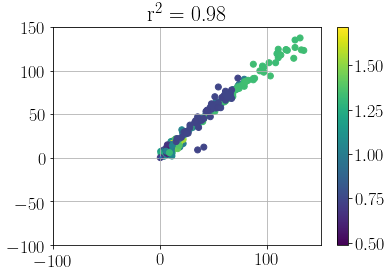

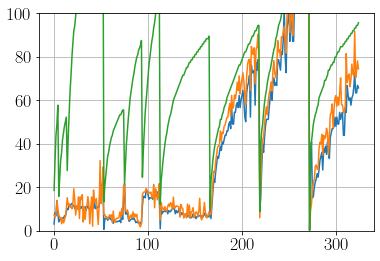

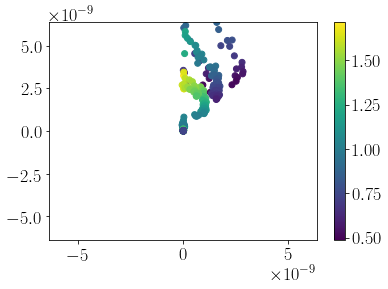

In [84]:
# Check how well h/H is reproduced using numerical values of <v'w'>
mask =  np.logical_and(MOdepth/(Htotal) < 1e100, ydata>0)
#mask =  np.logical_and(Ball/bfb>(1+S2a), mask)
mask =  np.logical_and(Ball/bfb>3, mask)
#mask[26:53] = False
#mask[80:106] = False

bfact = 1- S2a/(1+S2a)

alpha = (enttotal - 1)*(Ball+0*bfb*bfact)
entfact = 1+alpha/Ball/(1+S2a)
#entfact = enttotal
LHS = (Ball[mask])*entfact[mask]

#RHS = vpwp[mask]*test[mask] + Ball[mask] + 0*bfb[mask]*bfact[mask] + 0*bfh[mask]
RHS = vpwph[mask]*test[mask] + Ball[mask] - wpbpi[mask]/(1+S2a[mask]) 
nums = RHS/LHS
yvar = ydatah

#plt.figure()
#plt.scatter(vpwp[mask], vpwpscale[mask])
#l = np.max(np.abs(vpwp[mask]))
#plt.xlim(-l, l); plt.ylim(-l, l)
#plt.plot([-l, l], [-l, l])
#corr = np.corrcoef(np.array(vpwp)[mask], vpwpscale[mask])
#plt.title(f'r$^2$ = {corr[1,0]**2:.2}')

plt.figure()
plt.scatter(yvar[mask]*Htotal[mask], nums*Htotal[mask], c=np.log10(Ball/bfb)[mask])
plt.colorbar()
#plt.scatter(ydata[mask], numscale)

plt.plot([0,1], [0,1])
plt.ylim(-100, 150)
plt.xlim(-100,150)
plt.grid()
corr = np.corrcoef(np.array(yvar*Htotal)[mask], nums*Htotal[mask])
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')

plt.figure()
plt.plot(yvar[mask]*Htotal[mask])
plt.plot( nums*Htotal[mask])
plt.plot(Htotal[mask])
#plt.plot(numscale*Htotal[mask])
plt.grid()
plt.ylim(0, 100)

plt.figure()
plt.scatter( wpbpi[mask]/(1+S2a[mask]), Ball[mask]*(1-yvar[mask]), c=np.log10(Ball[mask]/bfb[mask]))
plt.colorbar()
xm = np.max(wpbpi[mask]/(1+S2a[mask]))
plt.xlim(-xm, xm)
plt.ylim(-xm, xm)

In [ ]:
plt.plot(S2a)
plt.xlim(0, 120)
plt.axvline(106)

In [ ]:
plt.plot(ydatah[mask]*LHS)
plt.plot(test[mask]*vpwph[mask] + Ball[mask])
plt.plot(-wpbpi[mask]/(1+S2a[mask]))
plt.plot(bfh[mask]+bfb[mask]-vzh[mask]*test[mask])


In [ ]:
plt.plot(wpbpi)
plt.grid()

## Define optimization function

In [108]:
def fithT(ent, H, BEK,EFACT, ydata):
    def fithH(factor, C): #factor is the combined coefficient of the highest order term (ie. Factor*(1-h/h)^3)
        nt = factor.size
        h = np.ones((nt))
        entm = np.mean(ent)
        for i in range(0, nt):
            def f(x):
                   #return  (1-x)*x**(2) - C**3*factor[i]**(1)*(1-ent[i]*x)**1
                   #return  (x-I)**1  - C**3*factor[i]**1*(1-ent[i]*x)**1
                   #return x**2 - C**3*factor[i]**1*(1-ent[i]*x)**1 
#                    return x**4 - C**3*factor[i]**4*(I-ent[i]*x)**3

                    return x**4 - C**3*factor[i]**4*(1-ent[i]*x)**3
#                   return  x**(1)*(1-x)**2 - C**3*(factor[i])**(1/3)*(1-ent[i]*x)**1
#                  return  (x)**(2) - C**3*(1+factor[i]**(-1/3))**(-2)*(1-ent[i]*x)**1


            if np.isfinite(factor[i]):
                #sol = optimize.root(f, [0.3, 0.8], method='lm')
                ##sol = optimize.root_scalar(f,x0=0.5)
                #if not sol.success:
                #    print('fail')
                #else:
                    #print(np.sort(sol.x))
                #    h[i] = (np.sort(sol.x)[1])
                hall, info, ier, n = optimize.fsolve(f, 0.4, maxfev=100000, full_output=True)
                h[i] = hall
                if ier != 1:
                    h[i] = 0
                    print(n)
                # = optimize.root_scalar(f, x0=ydata[i], x1=1, maxiter=1000)
                #xo, r = optimize.brentq(f, 0, 10, full_output=True)
                #if ~r.converged:
                #    print('fail')
                #    h[i] = 0
                #else:
                #    #h[i] = r.sol
                #    h[i] = xo
                
        return h*H
    return fithH


## Optimize for the coefficient in the cubic equation

In [109]:
# Optimize for H
yvar = ydatah
mask = np.logical_and(MOdepth/(Htotal) < 1e100, yvar>0)
#mask = np.logical_and(Ball/bfb>(1+S2a), mask) # USED IN MS
mask = np.logical_and(Ball/bfb>3, mask)
#mask = np.logical_and(Ball/bfb>3, mask)
#mask = np.logical_and(ustartotal**2/((1+S2a)*1e-4)/(1e-4/thta)>1, mask)
mask = np.logical_and(yvar<1, mask)
#mask = np.logical_and(S2a<3, mask)
#mask[26:53] = False
#mask[80:106] = False
alpha = (enttotal - 1)*(Ball)
entfact = 1+alpha/(Ball*(1+S2a))
en = enttotal
en = entfact
Hop = Htotal


fact = (Ball)/(((Ball)*Htotal)**(1/3)*test**2*Htotal)
#fact = (Ball+bfb)/((Ball*Htotal**(1/3) + 3*ustartotal**3)**(1/3)*test**2*Htotal**(1))
fact = (Ball+0*bfb)/( ((Ball+0*bfb)*Htotal)**(1/3)*test*0.1)
#fact = (Ball+bfb)/(0.1*(ustartotal**3 + 0.3*Htotal*(Ball+bfb))**(1/3)*test)
#fact = (Ball+bfb)**(1)/(((Ball+bfb)*Htotal + 10*ustartotal**3)**(1/3)*test*0.1)
#fact = (ustartotal**4/(0.1**3*test * Htotal**1))**(1/4)
#fact = (Ball+bfb)*/(Htotal**(1/3)*0.1*test)
fact = ustartotal/(0.1)*(ustartotal**3/Ball/Htotal)**(1/3)
fact = (ustartotal**1/((test*Htotal)))**(1)# + bfb/(ustartotal*test**2*Htotal)

#thta = np.sqrt(S2a/(1e4*bfb)*1e-8)
#fact = (ustartotal**1/((test*Htotal)))**(1)# + bfb/(ustartotal*test**2*Htotal)

#fact = (np.array(MOdepth/Htotal))**(1)
#fact = ustartotal**2/((Ball*Htotal)**(1/3)*Htotal*test)
#fact = ustartotal/0.1
#fact = ustartotal**1/(test*Htotal)/(1+Ball*Htotal/ustartotal**3)**(1/3)
#fact = ustartotal**1/((Ball*Htotal)**(1/3))**(1)
#act = fact**2
#fact = ustartotal**2/((8.3*0.4*0.1*(Ball+bfb)*Htotal +1.2*ustartotal**3)**(1/3)*0.1)
#fact = ustartotal**2/(((Ball)*Htotal )**(1/3)*0.1)
#fact = ustartotal/0.1
#fact = Ball/(Htotal*(Ball*Htotal)**(1/3)*test)
#thta = S2a/(1+S2a)/test*1e-4
#fact = ustartotal**1/((0.1)/(Ball*Htotal)**(1/3)) # with x^4/3 correlates at 0.76
#fact = (ustartotal/(0.1))*ustartotal/((Ball*Htotal)**(1/3))
#fact = fact**(1/3)*ustartotal/0.1
#fact = (1 + fact**(-1))**(-1/3)
#fact = fact**(1/3)
#fact = ustartotal**4/(0.1**3*Htotal*test)
#fact = np.array(MOdepth)/Htotal*ustartotal/0.1
#fact = np.sqrt(Ball/test**3)/Htotal
#fact = Ball/(test**3*Htotal**2)
#fact = np.array(ustartotal)**2*Htotal/(0.1**2*np.array(MOdepth))
efact = 0*(bfb)/(test**3*Htotal**2)#*(1-S2a/(1+S2a))
efact = (1e-4*test-bfb)/(np.abs(Ball)**(1/3)*Htotal**(4/3)*test)

## ASSUMING <v'w'> ~ u*(Bh)^(1/3)
efact = 1e-4*test/(ustartotal*np.abs(Ball)**(1/3)*Htotal**(1/3))

## ASSUMING <v'w'> ~ u*(Bh)^(1/3)
efact = 1e-4*test/(Htotal**2*test**2)

popt, pcov = optimize.curve_fit(fithT(en[mask], Hop[mask], Ball[mask], efact[mask], yvar[mask]),fact[mask], yvar[mask]*Hop[mask], p0=[0.7],
                                absolute_sigma=True, maxfev = 500)
print(popt)
print(pcov)

[7.36321039]
[[0.00293289]]


(0, 150)

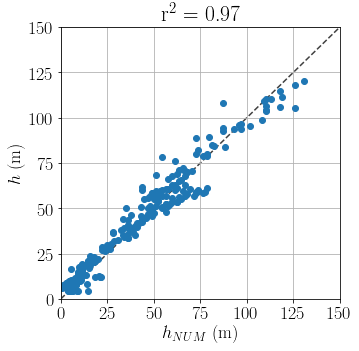

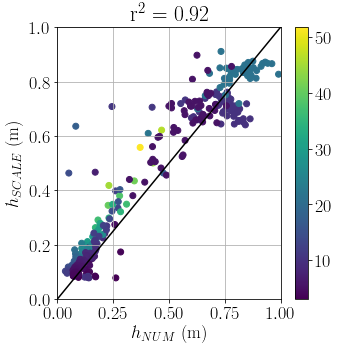

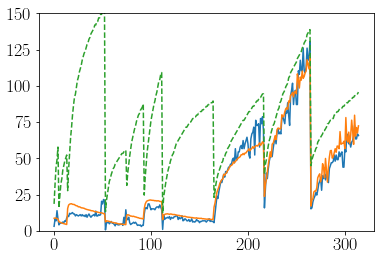

In [111]:
#mask =  np.logical_and(MOdepth/(Htotal) <1e10, ydata>1e-3)
#mask =  np.logical_and(Ball/bfb>0, mask)

Hop = Htotal
#en = enttotal

#fact = np.array(MOdepth/Htotal)

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

yvar = ydatah
#print(np.corrcoef(np.array(hntotal), y = fitn(en, Htotal)(np.array(factor), popt[0]))**2)
# plt.scatter(np.array(hntotal)/np.array(Htotal), fitH(np.array(factor), poptl[0]))
#fitt = fithT(en, Hop, S2a, ustartotal)(fact, 0.1, 0.33)/Hop
#fitt = fithT(en, Hop, S2a, ustartotal)(fact, 14, 0.38)/Hop
fitt = fithT(en, Hop, Ball, efact, yvar)(fact, popt[0])/Hop
#fitt = fithT(en, Hop, Ball, efact, yvar)(fact, 14.1, popt[1], popt[2])/Hop

#fitt = fithT(en, Hop, Ball, efact)(fact, 2.**(-3), popt[1])/Hop

plt.figure(figsize=(5,5))
plt.scatter(np.array(yvar)[mask]*Hop[mask], fitt[mask]*Hop[mask], zorder=2)
corr = np.corrcoef(np.array(yvar*Hop)[mask], np.array(fitt*Hop)[mask])
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')
plt.plot([0, np.max(Hop)], [0, np.max(Hop)], color='0.25', linestyle='--', zorder=1)
plt.ylim(0, 150); plt.xlim(0, 150)
plt.xticks([0, 25, 50, 75, 100, 125, 150])
plt.xlabel('$h_{NUM}$ (m)')
plt.ylabel('$h$ (m)')
plt.grid()

plt.savefig('./MSFigs/ConvTheory.pdf', bbox_inches='tight')


plt.figure(figsize=(5,5))
plt.scatter(np.array(yvar)[mask], fitt[mask], c = Ball[mask]/bfb[mask])
plt.colorbar()
corr = np.corrcoef(np.array(yvar)[mask], np.array(fitt)[mask])
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')
plt.plot([0, 1], [0, 1], color='k')
plt.ylim(0, 1); plt.xlim(0, 1)
plt.xlabel('$h_{NUM}$ (m)')
plt.ylabel('$h_{SCALE}$ (m)')
plt.grid()


plt.figure()
plt.plot((yvar*Hop)[mask])
plt.plot((fitt*Hop)[mask])
#plt.plot((nums*Hop[mask]))

#plt.plot((1-popt[1]/popt[0])*Hop[mask])
plt.plot(Hop[mask], linestyle='--')
plt.ylim(0, 150)

In [ ]:
mask = np.logical_and(MOdepth/(Htotal) < 1e10, yvar>0)
#mask = np.logical_and(Ball/bfb>(1+S2a), mask) # USED IN MS
mask = np.logical_and(Ball/bfb>4, mask)
mask.size - sum(mask)

In [ ]:
plt.semilogy(8**3*(fact)**4)

In [ ]:
plt.plot(Ball*(1+S2a)/bfb)
#plt.plot(Ball/bfb)
plt.plot(S2a)


In [ ]:
thta = np.sqrt(S2a/(1e4*bfb)*1e-8)
#plt.semilogy(Htotal*(1-ydata)/(thta/S2a))
plt.semilogy(Htotal/(thta/S2a))
plt.semilogy(Htotal)
plt.axhline(1000)
plt.axhline(100)

In [ ]:
plt.plot(Htotal/thta*S2a)
plt.axhline(100)

## REGRESS COEFFICIENT DIRECTLY FOR <V'W'>

In [ ]:
plt.plot(vpwp)
plt.plot(ydata*ustartotal**2 - ustartotal**2)

In [ ]:
 def fitFlux(sigma):
        def fitF(mag, C, I):
            nt = mag.size
            scale = np.ones((nt))
            for i in range(0, nt):
#                scale[i] =  C*mag[i]*(sigma[i] - 2*sigma[i]**2 + sigma[i]**3)
#                scale[i] = C*mag[i]*sigma[i] + I*ustartotal[i]**2/sigma[i]
#                scale[i] = C*test[i]**(-1)*ustartotal[i]**3/(ydata[i]*Htotal[i])*(0*I + ydata[i]*Htotal[i]/MOdepth[i])*(1-sigma[i])
#                scale[i] = C*mag[i]*(1-sigma[i]) 
                scale[i] = C*ustartotal[i]*ydata[i]*Htotal[i]*test[i]
            return scale
        return fitF

# Optimize for H
mask = np.logical_and(MOdepth/(Htotal) < 1e10, ydata>1e-3)
mask = np.logical_and(Ball/bfb>2, mask)

sigma = ydata
mag = ydata*test*(Ball*Htotal*ydata)**(1/3)*Htotal
mag = ydata*Htotal*test*(Ball*ydata*Htotal)**(1/3)
mag = (ustartotal)*(ustartotal**3 + 0.4*Ball*Htotal)**(1/3)

#mag = (ydata**2*Htotal**2*test**2)
#mag = ydata*Htotal*test*(Ball*Htotal)**(1/3)
#mag = ustartotal**2
popt, pcov = optimize.curve_fit(fitFlux(sigma[mask]),mag[mask], vpwp[mask], p0=[-3,10],
                                absolute_sigma=True, method='lm')

print(popt)
print(pcov)

fitFluxes = fitFlux(sigma)(mag, popt[0], popt[1])

plt.scatter(vpwp[mask], fitFluxes[mask])
#plt.scatter(vpwp[mask], -ustartotal[mask]**2)
l = np.max([np.max(np.abs(vpwp[mask])), np.max(np.abs(fitFluxes[mask]))])
plt.plot([-l, l], [-l, l])
plt.xlim(-l, l)
plt.ylim(-l, l)

corr = np.corrcoef(np.array(vpwp)[mask], np.array(fitFluxes)[mask])
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')

plt.figure()
plt.plot(vpwp[mask])
plt.plot(fitFluxes[mask])

LHS = (Ball[mask] )*enttotal[mask]
vpwpscale = fitFluxes[mask]
RHSs = vpwpscale*test[mask] + Ball[mask] 
nums = RHSs/LHS
RHS = vpwp[mask]*test[mask] + Ball[mask] 
num = RHS/LHS

plt.figure()
plt.plot((Htotal*ydata)[mask])
plt.plot(Htotal[mask]*nums)
plt.plot(Htotal[mask]*num)
plt.plot(Htotal[mask]*(popt[0]+1)/(popt[0]+enttotal[mask]))
corr = np.corrcoef(Htotal[mask]*ydata[mask], Htotal[mask]*nums)
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')

In [ ]:
plt.plot(ustartotal*Htotal)
plt.plot(ydata)

In [ ]:
# Optimize for H
mask = np.logical_and(MOdepth/(Htotal) < 1e10, ydata>1e-3)
mask = np.logical_and(S2a<1e10, mask)

def f(x, factor, C, ent):
#    return x**4*(1-2*x+x**2)**3 - C**3*factor**(4)*(1-ent*x)**3
    #return (x-0.4)**4 - C**3*factor**4*(1-ent*x)**3
    #return x**4/3*(1-2*x+x**2)**1 - C**1*factor**(1/3)*(1-ent*x)**1

    return x**4 - C**3*factor**4*(1-ent*x)**3

fact = 0.4*np.array(MOdepth/Htotal)[mask]
ent = enttotal[mask]
ns = ent.size
hH = np.zeros((ns,))
for i in range(0,ns):
    hall, info, ier, n = optimize.fsolve(f,  0.5, (fact[i], popt[0]**(-1), ent[i]), 
                                        maxfev=100000, full_output=True)

    if ier != 0:
        hall = [0, 0]

    hH[i] = hall[inda]
    #sol = optimize.root(f, [0.5], (fact[i], -popt[0]**(-1), ent[i]), method='lm')
    #inda = np.argmin(np.abs(sol.x - ydata[i]))
    #hH[i] = sol.x[inda]
    
alpha = -popt[0]**(-3)*(MOdepth/Htotal)**4
Q = ((27*alpha**2 + np.sqrt(729*alpha**4 + 6912*alpha**3))/2)**(1/3)
S = 0.5*np.sqrt(2*alpha + 0.25*alpha**2 + 1/3*(Q - 12*alpha/Q))
q = 1/8*alpha*((alpha-2)**2 + 20)
p = -3/8*alpha**2 - 3*alpha

#hH = -alpha/4 - S + 0.5*np.sqrt(-4*S**2 - 2*p + q/S)
     
plt.figure()
plt.scatter((ydata*Htotal)[mask], hH*Htotal[mask], c=np.log10(alpha[mask]))
plt.ylim(-0, 150)
plt.xlim(-0, 150)
plt.colorbar()
plt.grid()
corr = np.corrcoef(np.array(ydata*Htotal)[mask], np.array(hH*Htotal[mask]))
plt.title(f'r$^2$ = {corr[1,0]**2:.2}')

plt.figure()
plt.plot((ydata*Htotal)[mask])
plt.plot(hH*Htotal[mask])
plt.plot(Htotal[mask])

In [ ]:
# TEST FOR ROOTS

def f(x, factor, C):
#    return x**4*(1-2*x+x**2)**3 - C**3*factor**(4)*(1-x)**3
#    return x**4 - C**3*factor**(4)*(1-x)**3
    return x**1 - C**3*factor**(1)*(1-x)**3


fa = 2e-1
hall, info, ier, n = optimize.fsolve(f,  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], (fa, 1), maxfev=100000, full_output=True)

print(ier)
sig = np.linspace(0, 1)
plt.plot(0*hall, hall, marker='x')
plt.plot(f(sig, fa, 1), sig)

In [ ]:
def f(x, factor, C, ent):
    return x**4*(1-2*x+x**2)**3 - C*factor**(4)*(1-ent*x)**3
#    return x**4 - C**3*factor**(4)*(1-x)**3
    return x**2 - C*factor**(2)*(1-ent*x)

fact = 0.4*np.array(MOdepth/Htotal)[mask]
C = 0.1
ent = enttotal[mask]
ns = ent.size
hH = np.zeros((ns,))
for i in range(0,ns):
    hall, info, ier, n = optimize.fsolve(f,  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], (fact[i], C, ent[i]), maxfev=100000, full_output=True)

    if ier != 1:
        hall = [0, 0]
        print('fail')
    inda = np.argmin(np.abs(hall - ydata[i]))
    #print(inda)
    hH[i] = hall[inda]
    #sol = optimize.root(f, [0.5], (fact[i], -popt[0]**(-1), ent[i]), method='lm')
    #inda = np.argmin(np.abs(sol.x - ydata[i]))
    #hH[i] = sol.x[inda]
plt.plot(ydata[mask])
plt.plot(hH)

In [ ]:
plt.scatter(ydata, (Htotal*test/ustartotal)**(-2), c=test)
plt.colorbar()
plt.ylim(0, 10)

In [ ]:
plt.plot(vpwp)

#plt.plot(1e-1*(ydata*Htotal)**(2)*test**2)
plt.plot(-1e-1*0.1*ydata*ustartotal)
plt.plot(-1e-2*0.1*(Ball*ydata*Htotal)**(1/3))
beta = popt[0]**(-1)
alpha = popt[1]*beta
#plt.plot(-(ustartotal*(1-ydata))**2, linestyle='--')
cd = 1e-3
#plt.plot(-0.01*Htotal*(1-ydata)*test*(Ball*ydata*Htotal)**(1/3))
#plt.plot(-0.01*(ydata*Htotal)**2*test**2)
#plt.plot(-ustartotal*(Ball*ydata*Htotal)**(1/3))
#plt.plot(-0.3*ustartotal*(Ball*ydata*Htotal)**(1/3))
#plt.plot(-0.01*(ydata*Htotal - 0.5*Htotal)**2*test**2)
#plt.plot(-4*ustartotal**2*ydata**2)
#plt.plot(-1e-2*ydata*Htotal*test*(Ball*ydata*Htotal)**(1/3))
#plt.plot(0.001*(ydata*Htotal)**2*test**2)
#plt.plot(-cd*(0.1-Htotal*test)**2)
#plt.plot(-cd*0.1**2 - cd*(Htotal*test)**2 + 2*cd*Htotal*test*0.1)
#plt.plot(-0.25*ustartotal*(Ball*ydata*Htotal)**(1/3))
#plt.plot(-0.4*ustartotal**2 - 0.1*ustartotal*(Ball*ydata*Htotal)**(1/3))
#plt.plot(-0.4*ustartotal**2 - 0.01*ustartotal*ydata*Htotal*test)
#plt.plot(-0.1*(np.array(MOdepth)**2*test**2), color='g')

#plt.plot(-0.3*ustartotal**2 - 0.005*(ydata*Htotal*test)**2*(Ball*ydata*Htotal)**(1/3))

#plt.plot(-ustartotal**2 + 0.0*ydata*Htotal*test*(Ball*ydata*Htotal)**(1/3))

#plt.ylim(-1e-5, 1e-5)

In [ ]:
plt.plot(ydata)
plt.plot(1+vpwp/ustartotal**2)
plt.plot(-vpwp/
#plt.plot( vpwp/(integrate.cumtrapz(bfb, x=time, initial=0)))
#plt.ylim(-1, 1)

In [ ]:
plt.plot(ydata*Htotal)
plt.plot(Htotal)
plt.plot(Htotal/(1 + 20*np.array(MOdepth/Htotal)))
plt.ylim(0, 100)

In [ ]:
plt.plot(ustartotal**2)
cd = 2e-3
plt.plot(cd*(0.1-test*Htotal)**2)
plt.plot( cd*0.1**2 - 2*cd*0.1*test*Htotal)

In [ ]:
mask = np.array(MOdepth/Htotal)< 0.5
plt.plot(ydata[mask])
plt.plot(np.sqrt(1e-4/test[mask]/0.4))
plt.ylim(0, 1)
print(np.sqrt(np.mean(1e-4/test[mask])))
print((np.abs(popt[-1])))

# Extras

In [ ]:
plt.plot(ydata*Htotal)
plt.plot(0.8*( 1 - 0.55*Htotal*test/0.1)*Htotal/(enttotal))

In [ ]:
fig, ax = plt.subplots()
ax.plot((ustartotal)/1e-4/Htotal)
#ax.set_ylim(0,1)
ax2 = ax.twinx()

ax2.plot(ydata)
ax2.set_ylim(0,1)
#plt.ylim(0,1)
#np.mean(0.4*ustartotal/1e-4/Htotal)

In [ ]:
h = np.array(ydata*Htotal)

plt.plot(vpwp)
#plt.plot(-ustartotal**2/0.4*(0.5 - h/MOdepth)*(1-np.array(ydata)))
plt.plot(-ustartotal**2*(1-ydata))
#plt.plot(1e-1*ustartotal**2/0.4*(-h/MOdepth)*(1-ydata))
plt.ylim(-1e-5, 1e-5)

In [ ]:
plt.plot(1-ydata)

In [ ]:
A = 0.3 + 1+0*ydata

plt.plot(ydata)
plt.plot(-1/4*(A-np.sqrt(A+4)*np.sqrt(A)))


In [ ]:
plt.plot(ydata)
#plt.plot(fitt)
#plt.plot(1-np.array(MOdepth)/(0.4*ustartotal/1e-4))
#plt.plot(1-np.array(MOdepth)/(1.4*ustartotal/np.sqrt(1e-4*np.sqrt(1e-6))))
plt.plot((1.4*ustartotal/1e-4)/(Htotal))
plt.plot(0.06*ustartotal/1e-4/MOdepth)
#plt.plot(5*np.array(MOdepth)/Htotal)
plt.ylim(0,1)
#plt.plot(1-(1+S2a)/(0.4*0.4*np.sqrt(S2a))*(1e-4)/np.sqrt(1e-5))

In [ ]:
np.mean(0.06*ustartotal/1e-4/MOdepth)

In [ ]:
plt.plot(1/test)

In [ ]:
mask = MOdepth/(ydata*Htotal)<1
plt.plot(ydata[mask]*Htotal[mask])
#np.array(test).shape
#plt.plot(1-(-0.043*np.array(vpwpscale)[mask]+5.9377e-6)*np.array(test)[mask]/(np.array(Ball)[mask]))
#plt.plot((1-a*np.array(test)[mask]*np.array(scale)[mask]/np.array(Ball)[mask]))
plt.plot( (1+0.7*test[mask]*scale[mask]/Ball[mask])*Htotal[mask])
    #plt.ylim(0,2)

In [ ]:
plt.plot(np.array(ydata))
plt.plot(1+np.array(test)/4000)

In [ ]:
nz, nf = np.array(vbf).shape
colors = ['r', 'g', 'b', 'k', 'c', 'm']
plt.figure(figsize=(10,10))
ci = 0
for i in range(0, 30,10):
    plt.plot(vbf[:,i], z/Htotal[i], color=colors[ci])
    plt.plot(0, ydata[i], color=colors[ci], marker='x')
    ci += 1
plt.grid()   
plt.ylim((0, 2))
plt.xlim((-1e-9, 1e-9))

In [ ]:
#plt.plot(qmean, z)
#plt.plot(qsmooth,z)
#plt.axvline(Qo*0.2)

ts = -1
V = 0.1
#plt.plot(qflux[0,:],z)
plt.plot(-test[ts]*vpwpa[ts,:], z)
plt.plot(vbf[:,ts], z)
#plt.plot(-test[ts]*vpwpa[ts,:]+vbf[:,ts], z, linestyle='dashed')
plt.axhline(Htotal[ts])
plt.axhline(ydata[ts]*Htotal[ts], color='r')
plt.axhline(MOdepth[ts], color='y')
plt.axvline(ustartotal[ts]**2*test[ts])
#plt.plot(ustartotal[ts]**2*test[ts]*(1-enttotal[ts]*z/Htotal[ts]), z)
#plt.plot(test[ts]*np.array(vpwpscale[ts])*(1-z/Htotal[ts]), z)
wstar = np.array(vpwpscale)[ts]/(test[ts]*ydata[ts]*Htotal[ts])
#plt.plot(2.5e-2*test[ts]*np.array((V - test[ts]*Htotal[ts])*wstar)*(1-enttotal[ts]*z/Htotal[ts]), z)
plt.axvline(2.5e-2*test[ts]*np.array((V - test[ts]*Htotal[ts])*wstar)*0.5, color='g')

#plt.plot(0.5*test[ts]*np.array(ustartotal[ts]*wstar)*(1-enttotal[ts]*z/Htotal[ts]), z)
#plt.plot(1.2e-2*test[ts]*np.array(test[ts]*Htotal[ts]*wstar)*(1-enttotal[ts]*z/Htotal[ts]), z)
plt.axvline(0.35*test[ts]*np.array(wstar*ustartotal[ts]), color='y')

plt.grid()
plt.title(MOdepth[ts]/Htotal[ts])
plt.ylim(0, 50)

In [ ]:
vpwpa = np.array(vpwpa)
vpwpa.shape

In [ ]:
np.mean(S2a/(1+S2a))


In [ ]:
bz.shape
plt.plot(np.mean(bz[-18:, :]+N**2, axis=0), z)
plt.axhline(hn)
plt.axhline(H)

In [ ]:
wbz = np.gradient(np.array(vbfa), axis=1)/np.gradient(z)
wbzz = np.gradient(wbz, axis=1)/np.gradient(z)
plt.plot(np.array(vbfa)[-1,:], z)
plt.plot(qm[-1,:], z)
plt.axhline(ydata[-1]*Htotal[-1])
plt.axhline(Htotal[-1])

In [ ]:
qm.shape

In [ ]:
# fit optimal in terms of h (rather than h/H)
# poptl, pcov = optimize.curve_fit(fitH, factor[:], ydata[:]*Htotal, p0=14)
# print(poptl[0])

mask = ydata<100
en = np.array(enttotal)
popt, pcov = optimize.curve_fit(fitn(en[mask], Htotal[mask]), factor[mask], ydata[mask]*Htotal[mask], p0=14)
print(popt[0])

print(np.corrcoef(np.array(hntotal), y = fitn(en, Htotal)(np.array(factor), popt[0]))**2)
# plt.scatter(np.array(hntotal)/np.array(Htotal), fitH(np.array(factor), poptl[0]))
fitt = fitn(en, Htotal)(np.array(factor), popt[0])
plt.scatter(np.array(hntotal), fitt)


plt.plot(np.array(hntotal), np.array(hntotal))

plt.grid()
plt.figure()
plt.plot(ydata)
plt.plot(fitt/Htotal)

# plt.plot(fitH(factor, poptl[0]))

In [ ]:
plt.figure()
plt.plot(ydata*Htotal)
plt.plot(fitn(en, Htotal)(factor, popt[0]))
#plt.plot(fitn(en, Htotal)(factor, 14))


In [ ]:
ci

In [ ]:
test.shape

In [ ]:
vbf

In [ ]:
nz, nf = np.array(vbf).shape
colors = ['r', 'g', 'b', 'k', 'c', 'm', 'r', 'g', 'b']
plt.figure(figsize=(10,10))
for i in range(8, nf, 10):
    plt.plot(vbf[:,i], z, color=plt.cm.jet(i/nf))
    #plt.plot(0, fitH(factor[i], popt[0]), marker='x')
    plt.plot(0, fitn(np.array([enttotal[i]]), Htotal[i])(np.array([factor[i]]), popt[0]), marker='o', color=plt.cm.jet(i/nf))
    plt.gca().set_prop_cycle(None)
    plt.plot(0, ydata[i]*Htotal[i],  marker='x',color=plt.cm.jet(i/nf))

plt.grid()   
plt.ylim((0, 50))
plt.xlim((-2e-10, 2e-10))
#lt.xlim((-1e-9, 1e-9))

In [ ]:

#plt.plot(fitH(factor, popt[0]))

## Test one specific run

In [ ]:
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/snapshots_0p10.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p05/snapshots/snapshots_1e-5_0p05.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_5e-7_0p42/snapshots/snapshots_5e-7_0p42.h5' #0.1 slope
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p0225/snapshots/snapshots_1e-5_0p0225.h5' #0.1 slope
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-5_0p02/snapshots/snapshots_1e-5_0p02.h5' #Ruan case F
#filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-7_0p005/snapshots/snapshots_1e-7_0p005.h5' #Ruan case A
filename = '/data/thomas/jacob13/SI_ON_A_SLOPE/SI_DNS/SI_1e-6_0p01/snapshots/snapshots_1e-6_0p01.h5'

f = h5py.File(filename, 'r')

# Get the data
data = list(f['tasks'])

# Basic parameters
N = f['tasks']['N'][0,0,0] #Interior stratification (background)
tht = f['tasks']['tht'] # Slope angle


# Load variables in physical space
b = f['tasks']['b'] # Perturbation buoyancy
v = f['tasks']['v'] # Along-slope direction
vbfr = f['tasks']['VBFr']
#vbfrot = f['tasks']['VBFrotated']
z = v.dims[2][0][:]
time = v.dims[0][0][:]
q = f['tasks']['PV']
qm = np.mean(q, axis=1)
Qo = 1e-4*N**2
vz = np.gradient(np.mean(v, axis=1), axis=-1)/np.gradient(z)
bz = np.gradient(np.mean(b, axis=1), axis=-1)/np.gradient(z)
# Calculate BEk
tauy = -1035*1e-4*vz[:,0] #Note that 1e-4 is the viscosity for the DNS
Bek = tauy/(1030*1e-4)*N**2*np.sin(tht[:,0,0])

# Calculate h

nt = time.size

h_H = []
Hq = []
x1 = []
for i in range(0, nt, 12):
    ti = range(i, i+12)
    vsmooth = np.mean(vbfr[ti,0,:]-0*1e-4*(bz[ti,:] + N**2), axis=0)
    #inds = np.where(np.diff(np.sign(vsmooth)) <0)[0]
    #inds = np.where(vsmooth>0)[-1] # shallowest point where w'b'>0

    qmean = integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)
    #indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
    #inds = np.where(inds<=indq)[0]
    inds = np.where(np.logical_and(vsmooth>0, qmean<=0))[0]
    if inds.size == 0:
        inds = [0]
    inds = [inds[-1]]
    
    hn = z[inds[0]]
# Calculate H
    nt = Bek.shape[0]

   

    # Try a direct calculation of H and entrainment
    indq = np.where(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z)>0)[0][0] 
    H = z[indq] - z[0]
    ent = np.mean(vbfr[ti,0,indq] - 1e-4*(bz[ti,indq] + N**2))

    Beka = np.mean(Bek[ti])
    Ha = H
    ha = hn
    factorPartial = Beka**2/(Ha*0.1**3)*(1e-4/(N**2*tht[0,0,0]))**3
    ydataPartial = ha/Ha     
    entPartial = 1 + ent/Beka
    
    h_H.append(ydataPartial)
    Hq.append(Ha)
    x1.append(fitn(np.array([entPartial]))(np.array([factorPartial]), popt[0]))
    
x1 = np.array(x1)
h_H = np.array(h_H)
Hq = np.array(Hq)

In [ ]:
x1.append(fitn(np.array([entPartial]))(np.array([factorPartial]), popt[0]))

In [ ]:
plt.plot(h_H*Hq)
plt.plot( x1[:,0]*Hq)

In [ ]:
x1.shape

In [ ]:
Hq.shape

In [ ]:
plt.plot(integrate.cumtrapz(np.mean(qm[ti,:], axis=0), x=z, initial=0)/z/Qo, z/Ha)
plt.plot(np.mean(qm[ti,:], axis=0)/Qo, z/Ha)
plt.axhline(z[indq]/Ha)

# plt.xlim(-2, 2)

In [ ]:
plt.plot(vsmooth, z/Ha)
plt.axhline(z[inds[0]]/Ha)

In [ ]:
plt.plot(integrate.cumtrapz(z, x=z, initial=z[0]), z)

In [ ]:
plt.plot(np.mean(GSP[ti,0,:], axis=0), z)
# plt.plot(np.mean(vbf))
plt.axhline(z[inds[0]])

In [ ]:
ts= 20
plt.plot(vpwpa[ts], z)
plt.plot(vbfa[ts], z)

plt.axhline(Htotal[ts], color='g')
plt.axhline(ydata[ts]*Htotal[ts])
plt.axhline(fitn(np.array([enttotal[ts]]), Htotal[ts])(np.array([factor[ts]]), popt[0]), color='r')
plt.ylim(0, 90)

In [ ]:
plt.scatter(ydata*Htotal, np.array(test)*Htotal)
plt.title(np.corrcoef(ydata, np.array(test)))

In [ ]:
plt.plot(np.mean(wq[ti,0,:]-0*1e-4*np.gradient(qm[ti,:], axis=-1)/np.gradient(z), axis=0), z/Ha)

In [ ]:
q.shape

In [ ]:
qm.shape

In [ ]:
plt.plot(Htotal)

In [ ]:
plt.plot(Htotal)

In [ ]:
wq.shape

In [ ]:
plt.plot(ustartotal)

In [ ]:
plt.plot(bfh+bfb)
plt.plot(bfh)
plt.plot(test*1e-4*test)

In [ ]:
plt.plot(-wbmin/wbmax)
plt.plot(0.5*1/(1+S2a))
plt.plot(ydata)
plt.ylim(0,1)

In [ ]:
plt.scatter(vpwp,2*ydata*(1-ydata**2)*0.5/(1+S2a)*Ball)
l = np.max([np.abs(vpwp), np.abs(2*ydata*(1-ydata**2)*Ball)])
plt.xlim(-l, l)
plt.ylim(-l, l)

In [ ]:
intdiss = (Ball*Htotal/2)
plt.plot(vbfi/(1+S2a)/intdiss)
#plt.plot(Ball)
plt.plot(-test*vpwpi/intdiss)
plt.plot((vbfi/(1+S2a)-test*vpwpi)/intdiss)

plt.ylim(-1, 1)

#plt.axvline(120)

In [ ]:
plt.plot((Htotal-Htotal**2)/(1+Htotal))
plt.plot(-ydata*Htotal)

In [ ]:
np.asarray(vbfa).shape

In [ ]:
i = 120
plt.plot(vbfa[i], zall[i])
plt.axhline(Htotal[i]*ydata[i])